In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
import matplotlib.ticker as mtick

## Design

In [2]:
sns.set(palette = 'tab10', style = 'white', font = 'arial', context = 'notebook')

In [3]:
ptOrder = ['trust','opt','pess','env']
ptLong = ['Trustful','Optimist','Pessimist','Envious']

## Load data

In [10]:
a = !pwd
base_dir = '/'.join(a[0].split('/')[0:-2])
print(base_dir)
sys.path.append('/'.join(a[0].split('/')[:4])+'/Python')
import FigureTools

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study3_NewPlayerTypes


In [11]:
gameDat = pd.read_csv(base_dir + '/Data/Cleaned/gameDat_study4.csv',
                      index_col = 0, dtype={ 'subID':str})
gameDat.head()

,sub,subID,worker,assignment,Block,Player,Type,Variant,Type_Total,Trial,...,GameType,Colors,CorrAns,GivenAns,ConfidenceNum,ScoreNum,ScoreCumulBlock,RT_radio,RT_submit,SelfReport
0,1,6001,AQT5PKG39SJJM,3KAKFY4PGVUG37QYGCWJI5QD8KEI3D,0,n.a.,pess,nat,pess_nat,0,...,SG,n.a.,coop,coop,50.0,1,1,34851.0,38989.0,n.a.
1,1,6001,AQT5PKG39SJJM,3KAKFY4PGVUG37QYGCWJI5QD8KEI3D,0,n.a.,pess,nat,pess_nat,1,...,PD,n.a.,def,def,50.0,1,2,20870.0,24642.0,n.a.
2,1,6001,AQT5PKG39SJJM,3KAKFY4PGVUG37QYGCWJI5QD8KEI3D,0,n.a.,pess,nat,pess_nat,2,...,SH,n.a.,def,def,50.0,1,3,7268.0,9664.0,n.a.
3,1,6001,AQT5PKG39SJJM,3KAKFY4PGVUG37QYGCWJI5QD8KEI3D,0,n.a.,pess,nat,pess_nat,3,...,HG,n.a.,coop,coop,70.0,1,4,8997.0,11736.0,n.a.
4,1,6001,AQT5PKG39SJJM,3KAKFY4PGVUG37QYGCWJI5QD8KEI3D,0,n.a.,pess,nat,pess_nat,4,...,SG,n.a.,coop,coop,60.0,1,5,5880.0,8617.0,n.a.


##### Exclude no-survey workers

In [13]:
workers_nosurvey = pd.read_csv(base_dir+'/Data/Cleaned/workers_without_survey.csv',index_col=0)['worker'].tolist()
gameDat = gameDat.loc[~gameDat['worker'].isin(workers_nosurvey),:].copy().reset_index(drop=True)

In [14]:
gameDat['AnsNum'] = gameDat['GivenAns'].apply(lambda x: int(x == 'coop'))
gameDat['phase'] = gameDat['Trial'].apply(lambda x: 'early' if x < 8 else 'late')
gameDat['Trial_total'] = gameDat['Block']*16 + gameDat['Trial']

In [15]:
blockDat = gameDat[['subID','Type','ConfidenceNum','ScoreNum']
                  ].groupby(['subID','Type'], as_index=False).mean()
blockDat = blockDat.rename(columns={'ConfidenceNum':'Confidence','ScoreNum':'Score'})
subIDs = blockDat['subID'].unique()
print(len(subIDs))
blockDat.head()

148


,subID,Type,Confidence,Score
0,6002,env,100.000,0.6875
1,6002,opt,99.375,0.6250
2,6002,pess,100.000,0.6250
3,6002,trust,100.000,0.6250
4,6003,env,78.750,0.8750


## Load model fits

In [18]:
def load_model_fits(date_string, features,
                    niter = 10, gaze = 'false', model_string = 'FeatureRL', fit_to = 'joint',
                   match_subIDs = None):
    
    print(date_string, features)
    
    model_fits = pd.read_csv(base_dir + 
         '/Data/Model/' +
         '%s_%s_%s_fitto-%s_gaze-%s_niter-%i.csv'%(
             model_string,features,date_string, fit_to, gaze, niter),
           index_col = 0, dtype={'sub_ID':str, 'comb':str, 'fit_to':str, 'sub_ind':int})
    if match_subIDs is not None:
        model_fits = model_fits.loc[model_fits['sub_ID'].isin(subIDs),:].copy().reset_index(drop=True)
    display(model_fits.head())
    print(model_fits.shape)
    print('%i'%len(model_fits['sub_ID'].unique())+' subjects loaded')
    return model_fits

### FeatureRL with motives (groups 1 and 2)

In [19]:
date_string = '2021-04-09'
features = 'CoGrRiNa'
model_fits = load_model_fits(date_string, features, match_subIDs=subIDs)

2021-04-09 CoGrRiNa


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,inv_temp,gaze_bias,feature_weight_1,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC
0,202,6002,joint,1,1,Nash,0,0,0,0.01,...,0.080,0.0,19.985,NaN,NaN,NaN,SSE,10.653,-33.438,79.353
1,202,6002,joint,2,10,Risk,0,0,0,0.01,...,0.032,0.0,19.995,NaN,NaN,NaN,SSE,14.407,-43.098,98.672
2,202,6002,joint,3,11,Risk_Nash,0,0,0,0.01,...,0.093,0.0,-3.008,19.994,NaN,NaN,SSE,10.570,-33.189,83.014
3,202,6002,joint,4,100,Greed,0,0,0,0.01,...,0.055,0.0,19.997,NaN,NaN,NaN,SSE,11.979,-37.193,86.863
4,202,6002,joint,5,101,Greed_Nash,0,0,0,0.01,...,0.062,0.0,10.001,19.996,NaN,NaN,SSE,10.009,-31.444,79.523


(2220, 21)
148 subjects loaded


##### Group 1: Extract full model fits (comb 1111)

In [20]:
group_1 = model_fits.query('comb == "1111"').copy().reset_index(drop=True)
group_1['model_descr'] = 'All Motives'
display(group_1.head())
group_1.shape

,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,gaze_bias,feature_weight_1,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,model_descr
0,202,6002,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.421,...,0.0,-0.350,2.562,1.106,2.915,SSE,9.539,-29.903,84.759,All Motives
1,203,6003,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.979,...,0.0,1.436,1.546,-1.663,0.873,SSE,4.107,-2.938,30.829,All Motives
2,204,6004,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.371,...,0.0,1.071,1.500,-0.374,-0.340,SSE,5.594,-12.823,50.599,All Motives
3,205,6005,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,4.341,...,0.0,-2.023,1.116,3.896,4.073,SSE,1.864,22.338,-19.723,All Motives
4,206,6006,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,1.087,...,0.0,2.712,-2.264,1.271,3.685,SSE,2.780,9.553,5.847,All Motives


(148, 22)

##### Group 2: Tag best model per subject

In [21]:
model_fits['best_model'] = False
for sub_ID in model_fits['sub_ID'].unique():
    sub_dat = model_fits.query('sub_ID == @sub_ID').sort_values(by='BIC',ascending=True).copy()
    best_model = sub_dat.iloc[0]
    best_BIC = best_model['BIC']
    model_fits.loc[(model_fits['sub_ID']==sub_ID) & (model_fits['BIC']==best_BIC),'best_model'] = True

In [22]:
group_2 = model_fits.query('best_model == True').copy().reset_index(drop=True)
group_2['model_descr'] = 'Best Motives'
display(group_2.head())
group_2.shape

,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_1,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,best_model,model_descr
0,202,6002,joint,9,1001,Coop_Nash,0,0,0,0.672,...,-0.289,4.479,NaN,NaN,SSE,9.730,-30.537,77.709,True,Best Motives
1,203,6003,joint,13,1101,Coop_Greed_Nash,0,0,0,1.886,...,2.412,2.085,0.328,NaN,SSE,3.189,5.163,10.469,True,Best Motives
2,204,6004,joint,12,1100,Coop_Greed,0,0,0,3.808,...,7.873,9.292,NaN,NaN,SSE,5.500,-12.284,41.204,True,Best Motives
3,205,6005,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,4.341,...,-2.023,1.116,3.896,4.073,SSE,1.864,22.338,-19.723,True,Best Motives
4,206,6006,joint,11,1011,Coop_Risk_Nash,0,0,0,2.591,...,4.494,2.486,3.440,NaN,SSE,2.329,15.212,-9.629,True,Best Motives


(148, 23)

##### Group3: Game Type + Intercept model

In [23]:
date_string = '2021-04-09'
features = 'CoHgShSgPd'
model_fits = load_model_fits(date_string, features, match_subIDs=subIDs)
group_3 = model_fits.query('comb == "11111"').copy().reset_index(drop=True)
group_3['model_descr'] = 'Game Types'

2021-04-09 CoHgShSgPd


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,gaze_bias,feature_weight_1,feature_weight_2,feature_weight_3,feature_weight_4,feature_weight_5,cost_type,SSE,LL,BIC
0,202,6002,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,0.177,...,0.0,-1.973,3.469,2.003,1.482,0.559,SSE,9.038,-28.177,85.466
1,203,6003,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,1.176,...,0.0,-0.479,3.926,3.031,0.131,1.100,SSE,2.964,7.505,14.102
2,204,6004,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,0.769,...,0.0,1.885,2.424,4.072,-1.746,-1.286,SSE,4.519,-6.042,41.195
3,205,6005,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,3.187,...,0.0,4.860,-2.402,-7.287,-6.378,-15.988,SSE,2.903,8.162,12.787
4,206,6006,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,1.011,...,0.0,3.634,0.848,-3.201,0.296,-4.036,SSE,2.626,11.379,6.355


(148, 22)
148 subjects loaded


##### Group 4: S,T pairs + Intercept model

In [24]:
date_string = '2021-05-07'
features = 'CoST'
model_fits = load_model_fits(date_string, features, match_subIDs=subIDs)
group_4 = model_fits.copy()
group_4['model_descr'] = 'Games'

2021-05-07 CoST


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_12,feature_weight_13,feature_weight_14,feature_weight_15,feature_weight_16,feature_weight_17,cost_type,SSE,LL,BIC
0,202,6002,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,4.282,...,6.087,-6.522,11.190,14.915,7.237,3.401,SSE,4.013,-2.196,83.411
1,203,6003,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,8.741,...,-4.494,-2.386,8.661,10.278,1.504,-5.728,SSE,0.889,46.050,-13.081
2,204,6004,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,4.668,...,-0.390,-4.523,5.109,2.240,-4.904,-5.323,SSE,3.745,-0.032,79.083
3,205,6005,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,1.100,...,-0.372,-0.676,4.047,1.304,0.344,-0.222,SSE,4.083,-2.746,84.511
4,206,6006,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,1.540,...,-0.646,-2.976,4.398,3.337,2.049,2.224,SSE,1.633,26.585,25.849


(148, 34)
148 subjects loaded


## Compare

In [25]:
all_model_fits = group_1.append(group_2).append(group_3).append(group_4)

/Users/jeroen/anaconda3/envs/struct_learn/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [26]:
all_model_fits.columns

Index(['BIC', 'LL', 'LR_down', 'LR_up', 'SSE', 'asymm_LR', 'best_model',
       'bounded_weights', 'comb', 'comb_index', 'cost_type', 'feature_names',
       'feature_weight_1', 'feature_weight_10', 'feature_weight_11',
       'feature_weight_12', 'feature_weight_13', 'feature_weight_14',
       'feature_weight_15', 'feature_weight_16', 'feature_weight_17',
       'feature_weight_2', 'feature_weight_3', 'feature_weight_4',
       'feature_weight_5', 'feature_weight_6', 'feature_weight_7',
       'feature_weight_8', 'feature_weight_9', 'fit_to', 'gaze', 'gaze_bias',
       'inv_temp', 'model_descr', 'sub_ID', 'sub_ind'],
      dtype='object')

##### Remove outliers

[-154.85, 199.54074999999997]


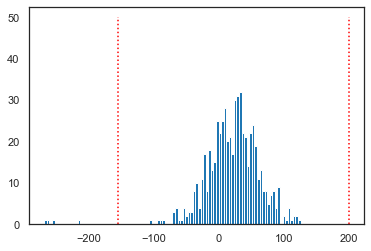

In [27]:
BICs = all_model_fits['BIC'].values
plt.hist(BICs, 100);
iqr = (all_model_fits['BIC'].describe()['75%'] - 
       all_model_fits['BIC'].describe()['25%'])
accepted_range = [all_model_fits['BIC'].describe()['25%'] - 3*iqr,
                  all_model_fits['BIC'].describe()['75%'] + 3*iqr]
min_BIC,max_BIC = accepted_range
print(accepted_range)
plt.plot([min_BIC,min_BIC],[0,50],'r:')
plt.plot([max_BIC,max_BIC],[0,50],'r:')

In [28]:
outlier_subjects = all_model_fits.query(
    '(BIC < @min_BIC | BIC > @max_BIC)')[
    ['sub_ind','sub_ID']].drop_duplicates()
outlier_sub_inds = outlier_subjects['sub_ind'].unique()
outlier_subjects

,sub_ind,sub_ID
133,339,8110


In [29]:
all_model_fits_cleaned = all_model_fits.loc[
    ~all_model_fits['sub_ID'].isin(outlier_subjects.sub_ID),:].copy()
all_model_fits_cleaned[['SSE','LL','BIC']].describe()

,SSE,LL,BIC
count,588.000000,588.000000,588.000000
mean,3.425406,7.941696,21.956769
std,1.936739,18.730289,37.145890
min,0.281000,-41.255000,-103.921000
25%,2.029250,-4.523750,-2.526500
50%,2.966500,7.473000,23.288500
75%,4.315750,19.618750,47.883250
max,13.601000,82.859000,125.480000


In [30]:
all_model_fits_cleaned['model_descr'].unique()

array(['All Motives', 'Best Motives', 'Game Types', 'Games'], dtype=object)

In [31]:
all_model_fits_cleaned.to_csv(base_dir + '/Data/Cleaned/all_model_fits_cleaned.csv')

## Load cleaned file

In [32]:
all_model_fits_cleaned = pd.read_csv(base_dir +
                 '/Data/Cleaned/all_model_fits_cleaned.csv', index_col = 0)
all_model_fits_cleaned.head()

,BIC,LL,LR_down,LR_up,SSE,asymm_LR,best_model,bounded_weights,comb,comb_index,...,feature_weight_7,feature_weight_8,feature_weight_9,fit_to,gaze,gaze_bias,inv_temp,model_descr,sub_ID,sub_ind
0,84.759,-29.903,0.421,0.421,9.539,0,NaN,0,1111,15,...,NaN,NaN,NaN,joint,0,0.0,0.364,All Motives,6002,202
1,30.829,-2.938,0.979,0.979,4.107,0,NaN,0,1111,15,...,NaN,NaN,NaN,joint,0,0.0,0.512,All Motives,6003,203
2,50.599,-12.823,0.371,0.371,5.594,0,NaN,0,1111,15,...,NaN,NaN,NaN,joint,0,0.0,0.888,All Motives,6004,204
3,-19.723,22.338,4.341,4.341,1.864,0,NaN,0,1111,15,...,NaN,NaN,NaN,joint,0,0.0,0.291,All Motives,6005,205
4,5.847,9.553,1.087,1.087,2.780,0,NaN,0,1111,15,...,NaN,NaN,NaN,joint,0,0.0,0.153,All Motives,6006,206


##### Plot

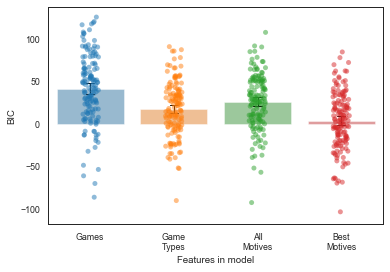

In [33]:
sns.set_context('paper')
fig,ax = plt.subplots(1,1,figsize = [6,4])
bar_order = ['Games','Game Types', 'All Motives', 'Best Motives']
xticklabels = ['\n'.join(a.split(' ')) for a in bar_order]

sns.barplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order, errcolor = 'k', capsize = .1, errwidth = 1)
sns.stripplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order)
# FigureTools.add_sig_markers(ax,relationships=[[2,3,0],[1,2,0]], distScale=.5, ystart = 30)
ax.set(ylabel = 'BIC', xlabel = 'Features in model',
      xticklabels = xticklabels);

##### Stats

In [34]:
def compare_models(name1,name2, plot_fig = True):
    testdat = all_model_fits_cleaned.query('model_descr == @name1 or model_descr == @name2')
    if plot_fig:
        fig,ax = plt.subplots(1,2,figsize=[10,3])
        sns.barplot(data = testdat, x = 'model_descr', y = 'BIC', ax = ax[0], order = [name1,name2], alpha = .5)
        sns.swarmplot(data = testdat, x = 'model_descr', y = 'BIC', ax = ax[0], order = [name1,name2], alpha = .5)
    testdat = testdat.pivot(index = 'sub_ID', columns = 'model_descr', values = 'BIC').dropna()
    diffs = testdat[name1] - testdat[name2]
    if plot_fig:
        ax[1].hist(diffs)
        ax[1].set(xlabel = '%s - %s'%(name1,name2))
    if scipy.stats.normaltest(diffs)[1] < 0.05:
        stats = scipy.stats.wilcoxon(testdat[name1], testdat[name2])
        test_type = 'nonparametric'
    else:
        stats = scipy.stats.ttest_rel(testdat[name1], testdat[name2])
        test_type = 'parametric'
    coh_d = (np.mean(diffs))/np.std(diffs)
    print('mean dBIC = %.2f +- %.2f, %i wins %i losses, %s stat = %.4f, p = %.4f, d = %.2f'%(
            np.mean(diffs), np.std(diffs), sum(diffs<0), sum(diffs>0), test_type, stats[0], stats[1], coh_d))
    return stats, diffs

In [35]:
model_list = bar_order
for name1 in model_list:
    for name2 in model_list:
        if name1 is not name2:
            print('%s minus %s: '%(name1,name2))
            stats,diffs = compare_models(name1,name2, plot_fig=False)
            print('')

Games minus Game Types: 
mean dBIC = 24.09 +- 28.97, 29 wins 118 losses, nonparametric stat = 1289.0000, p = 0.0000, d = 0.83

Games minus All Motives: 
mean dBIC = 15.44 +- 40.74, 43 wins 104 losses, nonparametric stat = 3027.0000, p = 0.0000, d = 0.38

Games minus Best Motives: 
mean dBIC = 37.74 +- 36.80, 19 wins 128 losses, nonparametric stat = 936.0000, p = 0.0000, d = 1.03

Game Types minus Games: 
mean dBIC = -24.09 +- 28.97, 118 wins 29 losses, nonparametric stat = 1289.0000, p = 0.0000, d = -0.83

Game Types minus All Motives: 
mean dBIC = -8.65 +- 20.74, 102 wins 45 losses, nonparametric stat = 2775.0000, p = 0.0000, d = -0.42

Game Types minus Best Motives: 
mean dBIC = 13.65 +- 18.86, 28 wins 119 losses, nonparametric stat = 1532.0000, p = 0.0000, d = 0.72

All Motives minus Games: 
mean dBIC = -15.44 +- 40.74, 104 wins 43 losses, nonparametric stat = 3027.0000, p = 0.0000, d = -0.38

All Motives minus Game Types: 
mean dBIC = 8.65 +- 20.74, 45 wins 102 losses, nonparametri

##### BIC with stat bars (Figure S3C)

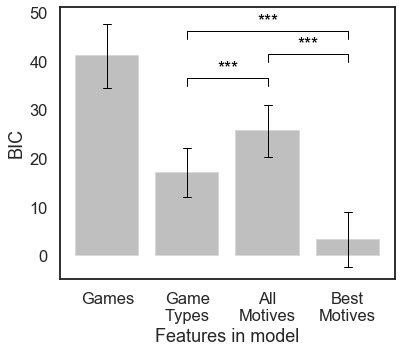

In [36]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize = [6,5])
# bar_order = ['S,T pairs', 'Game Types', 'All Motives', 'Best Motives']
xticklabels = ['\n'.join(a.split(' ')) for a in bar_order]
sns.barplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order, errcolor = 'k', capsize = .1, errwidth = 1, color = 'grey')
FigureTools.add_sig_markers(ax,relationships=[[1,2,0],[2,3,0],[1,3,0]], distScale = .5, ystart = 35)
ax.set(ylabel = 'BIC', xlabel = 'Features in model',
      xticklabels = xticklabels);